In [231]:
import os
import re
import gc
import ast
import csv
import sys 
import time
import codecs
import string
import logging
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier

import xgboost as xgb
import lightgbm as lgb
import catboost as cat

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Bidirectional, Dense, LSTM, Embedding, Dropout, Activation, Lambda
from keras.layers import Add, Flatten, BatchNormalization, concatenate, SpatialDropout1D
from keras.layers import Conv1D, GlobalMaxPool1D, GlobalAveragePooling1D, GlobalMaxPooling1D, MaxPooling1D, MaxPool1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as Ke
from keras.engine import InputSpec, Layer
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam, RMSprop

from scipy.spatial.distance import cosine
from gensim.models import Word2Vec, KeyedVectors

from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

import joblib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 200
pd.options.display.max_rows = 100

start_time = time.time()
np.random.seed(32)
os.environ["OMP_NUM_THREADS"] = "4"

import warnings
warnings.simplefilter('ignore')

In [168]:
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

import unidecode
import codecs
import spacy

In [169]:
def get_data():
    train = pd.read_csv("/kaggle/input/avalaraproduct-classification/train.tsv", sep="\t")
    test = pd.read_csv("/kaggle/input/avalaraproduct-classification/test.csv", sep="\t")
    
    print("Train Shape : {}\nTest Shape :  {}".format(train.shape, test.shape))
    
    return train, test

In [170]:
train, test = get_data()
train.head()

Train Shape : (1200000, 3)
Test Shape :  (92, 3)


,title,description,category
0,ZicZac // Black + Red (Euro: 44),Clothing & related products (B2C) - Shoes and shoe laces,R
1,9X9 RESISTA/484938,Publishing/Printing - Printing Services,S
2,Halle Pant - Short Inseam 013049561D0010001_ 02,Clothing & related products (B2C) - General,R
3,Harry Houser Travel Expenses - Meals,Security - personnel,S
4,Tee Time: 740078609 : Greens Fee - Composite,Admissions - Green Fees for Privately Owned Golf Course,R


In [171]:
train.dropna(inplace=True)

In [172]:
skf = StratifiedKFold(n_splits=10, random_state=13)

train['fold_id'] = np.nan

for i, (trn_idx, val_idx) in enumerate(skf.split(train, train['category']), 1):
    print("Split : {}".format(i))
    train['fold_id'].iloc[val_idx] = i
    print("--"*30)
train['fold_id'] = train['fold_id'].astype(np.int)

train['source'] = np.nan

new_df = pd.DataFrame()

for i in tqdm_notebook(train['fold_id'].unique()):
#     print(i)
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=13)
    train_subsample = train[train['fold_id'] == i].copy()
    train_subsample.reset_index(drop=True, inplace=True)
    
    for idx, (trn_idx, val_idx) in enumerate(gss.split(
        X=train_subsample, y=train_subsample['category'], groups=train_subsample['description'])):
        
        train_set = train_subsample.iloc[trn_idx]
        valid_set = train_subsample.iloc[val_idx]

        train_subsample['source'].iloc[trn_idx] = "train"
        train_subsample['source'].iloc[val_idx] = "valid"
        
        print(len(set.intersection(set(train_set['description'].values), set(valid_set['description'].values))))
    new_df = pd.concat([new_df, train_subsample], axis=0)
    new_df.reset_index(drop=True, inplace=True)
#     print(new_df.shape)

Split : 1
------------------------------------------------------------
Split : 2
------------------------------------------------------------
Split : 3
------------------------------------------------------------
Split : 4
------------------------------------------------------------
Split : 5
------------------------------------------------------------
Split : 6
------------------------------------------------------------
Split : 7
------------------------------------------------------------
Split : 8
------------------------------------------------------------
Split : 9
------------------------------------------------------------
Split : 10
------------------------------------------------------------


0
0
0
0
0
0
0
0
0
0



In [173]:
train = new_df.copy()
del new_df
gc.collect()

train.isnull().sum()

title          0
description    0
category       0
fold_id        0
source         0
dtype: int64

In [174]:
train.to_csv("train_10_skf.csv", index=False)

In [175]:
K = 1

In [176]:
def get_data():
    train = pd.read_csv("train_10_skf.csv")
    test = pd.read_csv("/kaggle/input/avalaraproduct-classification/test.csv", sep="\t")
    
    print("Train Shape : {}\nTest Shape :  {}".format(train.shape, test.shape))
    
    return train, test

In [177]:
test.fillna("none", inplace=True)

In [178]:
wnl = WordNetLemmatizer()

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "can't've": "cannot have", "'cause": "because", "could've": "could have", "couldn't": "could not", "couldn't've": "could not have","didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not",  "he'd": "he would", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not","sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have","that's": "that is", "there'd": "there would", "there'd've": "there would have","there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }
stop_words = set(stopwords.words('english'))

def treat_text(X):
    # Decoding 
    try:
        decoded = unidecode.unidecode(codecs.decode(X, 'unicode_escape'))
    except:
        decoded = unidecode.unidecode(X)

    # Handling apostrophes
    apostrophe_handled = re.sub("’", "'", decoded)
    X = " ".join([contraction_mapping[t] if t in contraction_mapping else t for t in apostrophe_handled.split(" ")])
    
    # Keeping only text + numbers and lowered.
    X = re.findall(r"[a-zA-Z0-9]+", X.lower())
    
    # Removing stopwords
    X = [word for word in X if (word not in stop_words)]
    
    # Lemming
#     X = [wnl.lemmatize(word) for word in X]
    
    return " ".join(X)

In [179]:
print("Sample Preprocessing \n")
for i in range(3):
    item = train['title'].iloc[i]
    print("Original Text : {}\nPreprocessed Text : {}\n".format(item, treat_text(item)))

Sample Preprocessing 

Original Text : ZicZac // Black + Red (Euro: 44)
Preprocessed Text : ziczac black red euro 44

Original Text : 9X9 RESISTA/484938
Preprocessed Text : 9x9 resista 484938

Original Text : Halle Pant - Short Inseam 013049561D0010001_ 02
Preprocessed Text : halle pant short inseam 013049561d0010001 02



In [180]:
for data in [train, test]:
    data['title'] = data['title'].progress_apply(lambda x: treat_text(x))
    data['description'] = data['description'].progress_apply(lambda x: treat_text(x))
    data['text'] = data['title'] + " " + data['description']

100%|██████████| 92/92 [00:00<00:00, 21460.21it/s]


In [181]:
train.to_csv("train_ne.csv", index=False)
test.to_csv("test_ne.csv", index=False)

In [182]:
train.isnull().sum()

title          0
description    0
category       0
fold_id        0
source         0
text           0
dtype: int64

In [183]:
target = 'category'

In [184]:
test['description'][test['description'] == "none"] = np.nan
test['description'].isnull().sum()

16

In [185]:
def make_feature_vec(words, model, num_features):
    """
    Average the word vectors for a set of words
    """
    feature_vec = np.zeros((num_features,),dtype="float32")  # pre-initialize (for speed)
    nwords = 0.
    index2word_set = set(model.wv.index2word)  # words known to the model

    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            feature_vec = np.add(feature_vec, model[word])
    
    feature_vec = np.divide(feature_vec, nwords)
    return feature_vec

In [186]:
train['title_tokenized'] = train['title'].progress_apply(lambda x: x.split())
test['title_tokenized'] = test['title'].progress_apply(lambda x: x.split())

train_subsample = train[train['fold_id'] == K]
train_subsample.shape

100%|██████████| 92/92 [00:00<00:00, 48210.39it/s]


(120000, 7)

In [187]:
col = 'title'
values = train_subsample['{}_tokenized'.format(col)].values.tolist()
model = Word2Vec(values, min_count=10)
print("Length of Vocabulary : {}".format(len(model.wv.vocab)))

model.most_similar("shirt")

Length of Vocabulary : 5820


[('men', 0.9801139831542969),
 ('polo', 0.9693353176116943),
 ('long', 0.9682233333587646),
 ('jacket', 0.9652382135391235),
 ('sweatshirt', 0.9651938080787659),
 ('women', 0.961998701095581),
 ('hoodie', 0.9617142081260681),
 ('button', 0.9614996314048767),
 ('ladies', 0.9599067568778992),
 ('sleeve', 0.9585515856742859)]

In [188]:
train_sentence_embs = np.zeros((train_subsample.shape[0], 100))

for i in tqdm_notebook(range(train_subsample.shape[0])):
    train_sentence_embs[i] = make_feature_vec(train['title_tokenized'].iloc[i], model, 100)

In [189]:
test_sentence_embs = np.zeros((test.shape[0], 100))

for i in tqdm_notebook(range(test.shape[0])):
    test_sentence_embs[i] = make_feature_vec(test['title_tokenized'].iloc[i], model, 100)

In [190]:
def calc_cosine_similarity(train_vecs, test_vec):
    start_time = time.time()
    result = np.full(len(train_vecs), -9999, dtype=float)
    for idx, _ in enumerate(range(len(train_vecs))):
        r = 1 - cosine(train_vecs[idx], test_vec)
        if str(r) != "nan":
            result[idx] = r
    
    print("Time Taken : {:.2f}".format(time.time() - start_time))
    
    return np.argmax(result), result[np.argmax(result)]

In [191]:
null_idxs = test[test['description'].isnull()].index.tolist()

mapping = {}

for i in null_idxs:
    item = test['title'].iloc[i]
    mapping[i] = {}
    mapping[i]['test_title'] = item
    
    max_idx, max_sim = calc_cosine_similarity(train_sentence_embs, test_sentence_embs[i])
    print("Index : {} \t Similarity : {}".format(max_idx, max_sim))

    mapping[i]['train_title'] = train_subsample['title'].iloc[max_idx]
    mapping[i]['mapped_desc'] = train_subsample['description'].iloc[max_idx]
    
    print("Test Item : {}".format(item))
    print("Train Title Item matched : {}".format(mapping[i]['train_title']))
    print("Train Description mapped : {}".format(mapping[i]['mapped_desc']))
    print("--"*50)

Time Taken : 7.56
Index : 44706 	 Similarity : 0.9829737911680743
Test Item : carpet repairs
Train Title Item matched : cust shorted ctrl board trying repl batt
Train Description mapped : repair performed tpp equipment parts labor separately stated
----------------------------------------------------------------------------------------------------
Time Taken : 7.38
Index : 4611 	 Similarity : 0.9740908401710531
Test Item : vct floor refinishing
Train Title Item matched : fs436 us26d floor stop
Train Description mapped : hardware sold medical facility
----------------------------------------------------------------------------------------------------
Time Taken : 7.19
Index : 43582 	 Similarity : 0.9005709003919636
Test Item : clean carpet clean windows scrub buff vct floors
Train Title Item matched : front porch actor windows ba
Train Description mapped : computer software implementation prewritten software electronically downloaded
-----------------------------------------------------

In [192]:
for key, value in mapping.items():
    test['description'].iloc[key] = value['mapped_desc']

In [193]:
test['text'] = test['title'] + " " + test['description']
test.to_csv("test_ne_imputed.csv", index=False)
test.isnull().sum()

title              0
description        0
category           0
text               0
title_tokenized    0
dtype: int64

## Modelling - 1 : Frequency Based

In [194]:
def get_data(train, test):
    train = pd.read_csv("train_ne.csv")
    test = pd.read_csv("test_ne_imputed.csv")
    print("Train Shape : {}\nTest Shape :  {}".format(train.shape, test.shape))
    
    train = train[['fold_id', 'title', 'description', 'text', 'category', 'source']]
    test = test[['title', 'description', 'text', 'category']]
    train.dropna(inplace=True)
    
    return train, test

In [195]:
train, test = get_data(train, test)

Train Shape : (1199998, 6)
Test Shape :  (92, 5)


### Labelling Target

In [196]:
target = 'category'

le = LabelEncoder()
train[target] = le.fit_transform(train[target].values)
test[target] = le.transform(test[target].values)

y = train[target].values
y_test = test[target].values

print(le.classes_)

['R' 'S']


### Splitter

In [197]:
K = 6

In [198]:
def splitter(data, k=K):
    
    data_v1 = data[data['fold_id'] == k].copy()
    data_v1.reset_index(drop=True, inplace=True)
    
    train_set = data_v1[data_v1['source'] == 'train'].copy()
    valid_set = data_v1[data_v1['source'] == 'valid'].copy()
    train_set.reset_index(drop=True, inplace=True)
    valid_set.reset_index(drop=True, inplace=True)
    
    del data_v1
    gc.collect()
    
#     print(train_set.shape, valid_set.shape)
    
    return train_set['text'].values, valid_set['text'].values, train_set['category'].values, valid_set['category'].values

### Baseliner Utils

In [199]:
def eval_t(y_pred):
    return f1_score(y_test, y_pred)

def baseliner(X_train, X_valid, y_train, y_valid, X_test, cv=3, metric='f1'):
    print("Baseliner Models\n")
    eval_dict = {}
    models = [LogisticRegression(), GaussianNB(), lgb.LGBMClassifier(), RandomForestClassifier(),
              DecisionTreeClassifier(), ExtraTreeClassifier()
             ]
    # xgb.XGBClassifier(), GradientBoostingClassifier(), AdaBoostClassifier(), BaggingClassifier(), ExtraTreesClassifier() 
    print("Model Name \t | Train \t | Valid \t | Test ") #    | \t TRN   | \t  VAL
    print("--" * 30)
    
    for index, model in enumerate(models, 0):
        model_name = str(model).split("(")[0]
        eval_dict[model_name] = {}
        
        model.fit(X_train, y_train)
        train_f1 = f1_score(y_train, model.predict(X_train))
        valid_f1 = f1_score(y_valid, model.predict(X_valid))
        test_f1 = eval_t(model.predict(X_test))
        
        eval_dict[model_name]['train'] = train_f1
        eval_dict[model_name]['valid'] = valid_f1
        eval_dict[model_name]['test'] = test_f1
        
        print("%s \t | %.4f \t | %.4f \t | %.4f \t " % (
            model_name[:12], eval_dict[model_name]['train'], eval_dict[model_name]['valid'], eval_dict[model_name]['test']))

In [200]:
def tokenize(s): 
    return s.split()

In [201]:
def fit_and_return_vectorizer(train, test, vectorizer, text_col='text', subsample_train=False):

    total_texts = pd.concat([train[text_col], test[text_col]], axis=0)
    total_texts.reset_index(drop=True, inplace=True)

    vectorizer.fit(total_texts.values)
    if subsample_train:
#         k = np.random.choice(train['fold_id'].unique())
        print(f"Choosing Random Subsample Fold-ID : {K}")
        X_train, X_valid, y_train, y_valid = splitter(train)

    train_count_vect = vectorizer.transform(X_train)
    valid_count_vect = vectorizer.transform(X_valid)
    test_count_vect = vectorizer.transform(test[text_col].values)

    print("Number of features / words in vocab : {}".format(len(vectorizer.get_feature_names())))
    print("Transformed Shapes :: \nTrain : {}\nValid : {}\nTest :  {}".format(
        train_count_vect.shape, valid_count_vect.shape, test_count_vect.shape))
    
    del total_texts
    gc.collect()
    
    return vectorizer, train_count_vect, valid_count_vect, test_count_vect, y_train, y_valid

In [202]:
%%time

max_features = 1_000
vect = TfidfVectorizer(max_features=max_features)
vect, transformed_train, transformed_valid, transformed_test, y_new_train, y_new_valid = fit_and_return_vectorizer(
    train, test, vect, subsample_train=True)

Choosing Random Subsample Fold-ID : 6
Number of features / words in vocab : 1000
Transformed Shapes :: 
Train : (99371, 1000)
Valid : (20593, 1000)
Test :  (92, 1000)
CPU times: user 30.4 s, sys: 330 ms, total: 30.7 s
Wall time: 30.9 s


In [203]:
baseliner(transformed_train.toarray(), transformed_valid.toarray(), y_new_train, y_new_valid, transformed_test.toarray())

Baseliner Models

Model Name 	 | Train 	 | Valid 	 | Test 
------------------------------------------------------------
LogisticRegr 	 | 0.9988 	 | 0.9723 	 | 0.9057 	 
GaussianNB 	 | 0.9807 	 | 0.9618 	 | 0.9358 	 
LGBMClassifi 	 | 0.9999 	 | 0.9493 	 | 0.8515 	 
RandomForest 	 | 0.9999 	 | 0.9741 	 | 0.8824 	 
DecisionTree 	 | 0.9999 	 | 0.9684 	 | 0.8367 	 
ExtraTreeCla 	 | 0.9999 	 | 0.8586 	 | 0.8515 	 


### Confusion Matrix + Understanding Evaluation

In [204]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

def plot_classification_report(model, X_train, X_test, y_train, y_test):

    model.fit(X_train, y_train)
    T = 0.44
    preds = model.predict_proba(X_test)[:, 1]
    pred_probs = preds.copy()
    preds[preds >= T] = 1
    preds[preds < T] = 0
    
    cm = confusion_matrix(y_test, preds)
    print("Classification Report")
    print(classification_report(y_test, preds))
    class_names = ["R", "S"]  # name  of classes

    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu", fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    
    return pred_probs

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.97      0.91        35
           1       0.98      0.89      0.94        57

    accuracy                           0.92        92
   macro avg       0.92      0.93      0.92        92
weighted avg       0.93      0.92      0.92        92



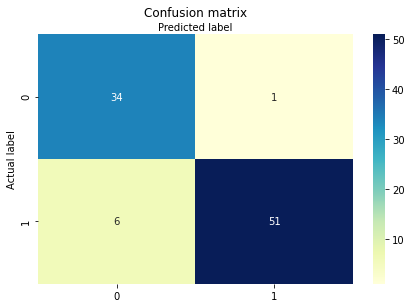

In [205]:
pred_probs = plot_classification_report(GaussianNB(), transformed_train.toarray(), transformed_test.toarray(), y_new_train, y_test)

It seems we have higher False Negatives i.e 6 predictions which are actually Positive which have been faslely classified as Negative.

### Does ensembling help?

In [206]:
good_models = {
    "gaussian_nb": GaussianNB(),
    "log_reg" : LogisticRegression(),
    "lgb" : lgb.LGBMClassifier(),
}

soft_preds = {}
hard_preds = {}

for model_name, model in good_models.items():
    
    print("Model : {}".format(model_name))
    hard_preds[model_name] = np.nan
    soft_preds[model_name] = np.nan
    
    model.fit(transformed_train.toarray(), y_new_train)
    train_score = f1_score(y_new_train, model.predict(transformed_train.toarray()))
    preds = model.predict(transformed_test.toarray())
    pred_probs = model.predict_proba(transformed_test.toarray())[:, 1]
    
    hard_preds[model_name] = preds
    soft_preds[model_name] = pred_probs
    
    test_score = eval_t(preds)
    print("Train Score : {:.4f}\nTest Score : {:.4f}".format(train_score, test_score))

Model : gaussian_nb
Train Score : 0.9807
Test Score : 0.9358
Model : log_reg
Train Score : 0.9988
Test Score : 0.9057
Model : lgb
Train Score : 0.9999
Test Score : 0.8515


In [207]:
def tweak_threshold(pred, truth):
    thresholds = []
    scores = []
    for thresh in np.arange(0.1, 0.501, 0.01):
        thresh = np.round(thresh, 2)
        thresholds.append(thresh)
        score = f1_score(truth, (pred>thresh).astype(int))
        scores.append(score)
    return np.max(scores), thresholds[np.argmax(scores)]

In [208]:
# 2. Soft-Voting
# Finding the best threshold for best F1-Score : 

ens_1 = (soft_preds['gaussian_nb'] + soft_preds['log_reg'] + soft_preds['lgb'])/3

# First getting the threshold value from train_predictions
score_val, threshold_val = tweak_threshold(model.predict_proba(transformed_train.toarray())[:, 1], y_new_train)
print(f"Scored {round(score_val, 4)} for threshold {threshold_val} on train data")

# Then getting the f1 score in test set using that threshold
ens_1[ens_1 >= threshold_val] = 1
ens_1[ens_1 < threshold_val] = 0

print(f"Scored {round(eval_t(ens_1), 4)} for threshold {threshold_val} on test data")

Scored 0.9999 for threshold 0.41 on train data
Scored 0.9259 for threshold 0.41 on test data


## Modelling - 2 : FlipCNN

In [209]:
class F1Evaluation(Callback):
    def __init__(self, validation_data=(), test_data=(), interval=1):
        super(Callback, self).__init__()
        
        self.interval = interval
        self.X_val, self.y_val = validation_data
        self.X_test, self.y_test = test_data
        self.y_val = self.y_val[:, 1]
        self.y_test = self.y_test[:, 1]
        self.T = 0.5
    
    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_val = self.model.predict(self.X_val, verbose=0)[:, 1]
            y_test = self.model.predict(self.X_test, verbose=0)[:, 1]
            y_val[y_val >= self.T] = 1
            y_val[y_val < self.T] = 0
            y_test[y_test >= self.T] = 1
            y_test[y_test < self.T] = 0
            
            val_score = f1_score(self.y_val, y_val)
            test_score = f1_score(self.y_test, y_test)
            print("F1 : Epoch : {} \t Valid Score : {:.4f} \t Test Score : {:.4f}".format(epoch+1, val_score, test_score))

In [210]:
def get_data():
    train = pd.read_csv("train_ne.csv")
    test = pd.read_csv("test_ne_imputed.csv")
    print("Train Shape : {}\nTest Shape :  {}".format(train.shape, test.shape))
    
    train = train[['fold_id', 'title', 'description', 'text', 'category', 'source']]
    test = test[['title', 'description', 'text', 'category']]
    train.dropna(inplace=True)
    
    return train, test

In [211]:
train, test = get_data()
target = 'category'

Train Shape : (1199998, 6)
Test Shape :  (92, 5)


In [212]:
train[target] = train[target].map({"R": 0, "S": 1})
train['target_S'] = np.nan
train['target_R'] = np.nan
train['target_R'] = 1 - train[target].values
train['target_S'] = train[target].values

train.drop([target], axis=1, inplace=True)

In [213]:
test[target] = test[target].map({"R": 0, "S": 1})
test['target_S'] = np.nan
test['target_R'] = np.nan
test['target_R'] = 1 - test[target].values
test['target_S'] = test[target].values

y_test_true = test['target_S'].values
test.drop([target], axis=1, inplace=True)

In [214]:
list_classes = ["target_R", "target_S"]

In [216]:
### Splitter
K = 6
def splitter(data, k=6):
    
    data_v1 = data[data['fold_id'] == k].copy()
    data_v1.reset_index(drop=True, inplace=True)
    
    train_set = data_v1[data_v1['source'] == 'train'].copy()
    valid_set = data_v1[data_v1['source'] == 'valid'].copy()
    train_set.reset_index(drop=True, inplace=True)
    valid_set.reset_index(drop=True, inplace=True)
    
    del data_v1
    gc.collect()

    return train_set, valid_set, train_set[list_classes].values, valid_set[list_classes].values

In [217]:
T = 0.5
def eval_t(y_pred, y_true=y_test_true):
    y_pred[y_pred >= T] = 1
    y_pred[y_pred < T] = 0
    
    return f1_score(y_true, y_pred)

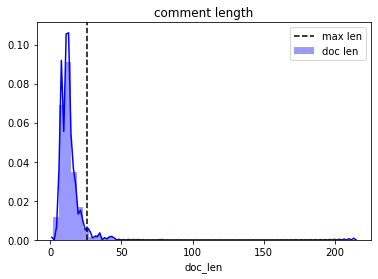

In [218]:
# visualize word length distribution
train['doc_len'] = train['text'].apply(lambda words: len(words.split(" ")))
max_len = np.round(train['doc_len'].mean() + 2*train['doc_len'].std()).astype(int)

sns.distplot(train['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_len, color='k', linestyle='--', label='max len')
plt.title('comment length')
plt.legend()
plt.show()

In [219]:
max_len

26

In [220]:
embed_size = 100
max_features = 1_000_000
max_len = 50

BS = 128

In [221]:
y_test = test[list_classes].values

X_train, X_valid, y_new_train, y_new_valid = splitter(train)
print(X_train.shape, X_valid.shape, y_new_train.shape, y_new_valid.shape)

(99371, 8) (20593, 8) (99371, 2) (20593, 2)


### Custom W2V

In [222]:
%%time

col = 'text'

values = train[col].progress_apply(lambda x: x.split()).values.tolist() + test[col].progress_apply(
    lambda x: x.split()).values.tolist()
embedding_index = Word2Vec(values, min_count=5, size=embed_size)
print("Length of Vocabulary : {}".format(len(embedding_index.wv.vocab)))

100%|██████████| 92/92 [00:00<00:00, 64355.57it/s]


Length of Vocabulary : 47157
CPU times: user 4min 2s, sys: 1.69 s, total: 4min 4s
Wall time: 2min 30s


In [223]:
embedding_index["shirt"].shape

(100,)

In [224]:
raw_text_train = X_train['text'].str.lower()
raw_text_valid = X_valid['text'].str.lower()
raw_text_test = test['text'].str.lower()

In [225]:
%%time

tk = Tokenizer(num_words=max_features, lower=True)
tk.fit_on_texts(raw_text_train.values.tolist() + raw_text_valid.values.tolist() + test['text'].values.tolist())
X_train['seq'] = tk.texts_to_sequences(raw_text_train.values)
X_valid['seq'] = tk.texts_to_sequences(raw_text_valid.values)
test['seq'] = tk.texts_to_sequences(raw_text_test.values)

X_train = pad_sequences(X_train.seq, maxlen=max_len)
X_valid = pad_sequences(X_valid.seq, maxlen=max_len)
test = pad_sequences(test.seq, maxlen=max_len)

CPU times: user 6.82 s, sys: 29.1 ms, total: 6.85 s
Wall time: 6.9 s


### Word2Vec : Coverage

In [226]:
word_index = tk.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix = np.zeros((nb_words, embed_size))
cnt = 0
for word, i in tqdm_notebook(word_index.items()):
    if i>= nb_words:
        continue
    try:
        embedding_vector = embedding_index[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            cnt += 1
    except KeyError:
        continue
cov = (cnt / nb_words)*100
print("Number of words : {}".format(nb_words))
print("Coverage : {:.2f}".format(cov))


Number of words : 157153
Coverage : 21.60


In [227]:
lr = 1e-3
lr_d = 0
units = 128
dr = 0.2

In [228]:
N_EPOCHS = 5
NUM_CLASSES = 2

In [232]:
def build_model_flipcnn_forward(test, embedding_matrix, lr=0.0, lr_d=0.0, units=0, dr=0.0, filename="flipcnn_forward"):
    
    file_path = "flipcnn_forward-{epoch:02d}.hdf5"
    check_point = ModelCheckpoint(file_path, monitor="val_loss", verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)
    f1_val = F1Evaluation(validation_data=(X_valid, y_new_valid), test_data=(test, y_test), interval=1)
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    
    filter_sizes = [1, 2, 3, 4, 5]
    num_filters = 36
    
    inp = Input(shape=(max_len, ))
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = SpatialDropout1D(dr)(x)
    
    conv_0 = Conv1D(num_filters, kernel_size=(filter_sizes[0]), kernel_initializer='he_normal', activation='relu')(x)
    conv_1 = Conv1D(num_filters, kernel_size=(filter_sizes[1]), kernel_initializer='he_normal', activation='relu')(x)
    conv_2 = Conv1D(num_filters, kernel_size=(filter_sizes[2]), kernel_initializer='he_normal', activation='relu')(x)
    conv_3 = Conv1D(num_filters, kernel_size=(filter_sizes[3]), kernel_initializer='he_normal', activation='relu')(x)
    
    maxpool_0 = MaxPool1D(pool_size=(max_len - filter_sizes[0] + 1))(conv_0)
    maxpool_1 = MaxPool1D(pool_size=(max_len - filter_sizes[1] + 1))(conv_1)
    maxpool_2 = MaxPool1D(pool_size=(max_len - filter_sizes[2] + 1))(conv_2)
    maxpool_3 = MaxPool1D(pool_size=(max_len - filter_sizes[3] + 1))(conv_3)
    
    z = concatenate([maxpool_0, maxpool_1, maxpool_2, maxpool_3])
    z = Flatten()(z)
    
    outp = Dense(NUM_CLASSES, activation="sigmoid")(z)
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss="binary_crossentropy", optimizer=Adam(lr=lr, decay=lr_d), metrics=['accuracy'])
    history = model.fit(X_train, y_new_train, batch_size=BS, epochs=N_EPOCHS, validation_data=(X_valid, y_new_valid), verbose=1, 
                        callbacks=[f1_val, check_point, early_stop])
    preds = model.predict(test, batch_size=1024, verbose=1)[:, 1]
    
    return model, preds

def build_model_flipcnn_backward(test, embedding_matrix, lr=0.0, lr_d=0.0, units=0, dr=0.0, filename="flipcnn_backward"):
    
    file_path = "flipcnn_backward-{epoch:02d}.hdf5"
    check_point = ModelCheckpoint(file_path, monitor="val_loss", verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)
    f1_val = F1Evaluation(validation_data=(X_valid, y_new_valid), test_data=(test, y_test), interval=1)
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    
    filter_sizes = [1, 2, 3, 4, 5]
    num_filters = 36
    
    inp = Input(shape=(max_len, )) 
    x = Lambda(lambda x: Ke.reverse(x, axes=-1))(inp)
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = SpatialDropout1D(dr)(x)
    
    conv_0 = Conv1D(num_filters, kernel_size=(filter_sizes[0]), kernel_initializer='he_normal', activation='relu')(x)
    conv_1 = Conv1D(num_filters, kernel_size=(filter_sizes[1]), kernel_initializer='he_normal', activation='relu')(x)
    conv_2 = Conv1D(num_filters, kernel_size=(filter_sizes[2]), kernel_initializer='he_normal', activation='relu')(x)
    conv_3 = Conv1D(num_filters, kernel_size=(filter_sizes[3]), kernel_initializer='he_normal', activation='relu')(x)
    
    maxpool_0 = MaxPool1D(pool_size=(max_len - filter_sizes[0] + 1))(conv_0)
    maxpool_1 = MaxPool1D(pool_size=(max_len - filter_sizes[1] + 1))(conv_1)
    maxpool_2 = MaxPool1D(pool_size=(max_len - filter_sizes[2] + 1))(conv_2)
    maxpool_3 = MaxPool1D(pool_size=(max_len - filter_sizes[3] + 1))(conv_3)
    
    z = concatenate([maxpool_0, maxpool_1, maxpool_2, maxpool_3])
    z = Flatten()(z)
    
    outp = Dense(NUM_CLASSES, activation="sigmoid")(z)
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss="binary_crossentropy", optimizer=Adam(lr=lr, decay=lr_d), metrics=['accuracy'])
    history = model.fit(X_train, y_new_train, batch_size=BS, epochs=N_EPOCHS, validation_data=(X_valid, y_new_valid), verbose=1, 
                        callbacks=[f1_val, check_point, early_stop])
    preds = model.predict(test, batch_size=1024, verbose=1)[:, 1]
    
    return model, preds


def build_model_flipcnn(test, embedding_matrix, lr=0.0, lr_d=0.0, units=0, dr=0.0):
    model_1, preds_1 = build_model_flipcnn_forward(test, embedding_matrix, lr=lr, lr_d=lr_d, units=units, dr=dr, filename="flipcnn_forward")
    model_2, preds_2 = build_model_flipcnn_backward(test, embedding_matrix, lr=lr, lr_d=lr_d, units=units, dr=dr, filename="flipcnn_backward")
    
    preds = (preds_1 + preds_2)/2
    
    return model_1, model_2, preds, preds_1, preds_2

In [233]:
model_fow, model_back, avg_preds, for_preds, back_preds = build_model_flipcnn(test, embedding_matrix, lr=lr, lr_d=lr_d, units=units, dr=dr)

Train on 99371 samples, validate on 20593 samples
Epoch 1/5
99371/99371 [==============================] - 6s 56us/step - loss: 0.0203 - accuracy: 0.9940 - val_loss: 0.1647 - val_accuracy: 0.9647
F1 : Epoch : 1 	 Valid Score : 0.9783 	 Test Score : 0.9245

Epoch 00001: saving model to flipcnn_forward-01.hdf5
Epoch 2/5
99371/99371 [==============================] - 5s 49us/step - loss: 0.0024 - accuracy: 0.9992 - val_loss: 0.1815 - val_accuracy: 0.9640
F1 : Epoch : 2 	 Valid Score : 0.9778 	 Test Score : 0.9143

Epoch 00002: saving model to flipcnn_forward-02.hdf5
Epoch 3/5
99371/99371 [==============================] - 5s 51us/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 0.1781 - val_accuracy: 0.9639
F1 : Epoch : 3 	 Valid Score : 0.9776 	 Test Score : 0.9143

Epoch 00003: saving model to flipcnn_forward-03.hdf5
Epoch 4/5
99371/99371 [==============================] - 5s 49us/step - loss: 4.6507e-04 - accuracy: 0.9999 - val_loss: 0.2495 - val_accuracy: 0.9579
F1 : Epoch : 4 	 Val

In [234]:
# # Best epochs indexes : 
# 1. For : 1 0.9245
# 2. Back : 5 0.9245

eval_t(avg_preds), eval_t(for_preds), eval_t(back_preds)

(0.9245283018867925, 0.9142857142857143, 0.9245283018867925)

In [235]:
# Best epochs indexes 

sub = pd.DataFrame()
best_epoch_dict = {
    "flipcnn_forward" : [1, model_fow],
    "flipcnn_backward" : [5, model_back],
}
avg_preds = np.zeros(for_preds.shape[0])

for key, (epoch_id, model) in best_epoch_dict.items():
    model_path = "{}-0{}.hdf5".format(key, epoch_id)
    print(model_path)
    model.load_weights(model_path)
    preds = model.predict(test, batch_size=1024, verbose=1)[:, 1]
    sub[key] = preds
    
    if key in ['flipcnn_forward', 'flipcnn_backward']:
        avg_preds += preds
avg_preds /= 2
sub['flipcnn_average'] = avg_preds

sub.head()

flipcnn_forward-01.hdf5
92/92 [==============================] - 0s 26us/step
flipcnn_backward-05.hdf5
92/92 [==============================] - 0s 24us/step


,flipcnn_forward,flipcnn_backward,flipcnn_average
0,0.000015,0.000011,0.000013
1,0.961477,0.999855,0.980666
2,0.999987,0.999994,0.999991
3,1.000000,1.000000,1.000000
4,0.000048,0.000006,0.000027


In [1]:
# eval_t(sub['flipcnn_average']), eval_t(sub['flipcnn_backward']), eval_t(sub['flipcnn_forward'])

## Final Ensemble

In [237]:
test = pd.read_csv("test_ne_imputed.csv")
target = 'category'
y_test = test[target].map({"R": 0, "S": 1}).values

In [240]:
T = 0.5
ens_1 = (((soft_preds['gaussian_nb'] + soft_preds['log_reg'] + soft_preds['lgb'])/3) + (sub['flipcnn_backward']))/2

print("Best Ensemble Model Scored {} on test data".format(f1_score(y_test, (ens_1>T).astype(int))))

Best Ensemble Model Scored 0.9541 on test data


## END